<a href="https://colab.research.google.com/github/JINU6497/JINUrepo/blob/master/Design_CNN_by_using_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
'''1. Module Import'''
import numpy as np  # 선형대수 관련 모듈
import matplotlib.pyplot as plt  # 결과 산출물을 시각화하는 모듈
 
import torch
import torch.nn as nn  # 인공 신경망 모델 설계에 필요한 함수들 모아 놓은 모듈 
import torch.nn.functional as F # torch.nn 중에서도 자주 쓰이는 functional 함수들을 따로 F로 지정 
from torchvision import transforms, datasets  # Computer vision 분야에서 자주 이용되는 torchvision 내의 함수 임포트

In [41]:
'''2. 딥러닝 모델 설계에 활용하는 장비 확인'''
if torch.cuda.is_available():
  DEVICE=torch.device('cuda')
else:
  DEVICE=torch.device('cpu')
 
print("Using pytorch version:",torch.__version__,'Device:',DEVICE)

Using pytorch version: 1.9.0+cu102 Device: cpu


In [42]:
BATCH_SIZE = 32
EPOCHS = 10

In [43]:
'''3. FashionMNIST 데이터 다운로드(Train과 Test set 분리)'''
train_dataset=datasets.CIFAR10(root="../data/Fashion,MNIST",train=True,download=True,transform=transforms.ToTensor())
test_dataset=datasets.CIFAR10(root="../data/Fashion,MNIST",train=False,transform=transforms.ToTensor())
 
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

Files already downloaded and verified


In [44]:
'''4. 데이터 확인'''
for (X_train, Y_train) in train_loader:
  print('X_train:',X_train.size(),'type:',X_train.type())
  print('Y_train:',Y_train.size(),'type:',Y_train.type())
  break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor


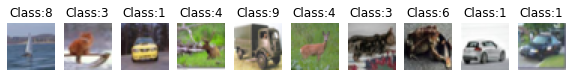

In [45]:
pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class:'+str(Y_train[i].item()))

In [46]:
'''5. Convolutional Neural Network(CNN) 모델 설계하기'''

class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1=nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
    self.conv2=nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
    self.pool=nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.fc1=nn.Linear(8*8*16,64)
    self.fc2=nn.Linear(64,32)
    self.fc3=nn.Linear(32,10)

  def forward(self, x):
    x=self.conv1(x)
    x=F.relu(x)
    x=self.pool(x)
    x=self.conv2(x)
    x=F.relu(x)
    x=self.pool(x)

    x=x.view(-1,8*8*16)
    x=self.fc1(x)
    x=F.relu(x)
    x=self.fc2(x)
    x=F.relu(x)
    x=self.fc3(x)
    x=F.log_softmax(x)

    return x

self.conv1=nn.conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1): 

in_channel: 이미지에 직접 Convolution 연산을 진행하는 Filter의 크기는 상관 없지만, 채널 수를 이미지의 채널 수와 동일하게 맞춰야 한다. 동일한 위치에 있으며 앞뒤로 존재하는 RGB 픽셀에 대해 동시에 Convolution을 진행해야 하기 때문. 따라서 이미지의 채널 수와 동일하게 채널 수를 3으로 설정.

out_channel은 8이므로 해당 Convolution 연산 결과는 Depth가 8인 Feature map이 생성 될 것.

kernel_size는 filter의 크기를 설정해주는 부분.

log_softmax()를 이용하여 0부터 9까지 총 10가지 경우의 수 중 하나로 분류하는 일을 확률 값 계산.일반적인 softmax가 아닌 log_softmax()를 이용하는 이유는 MLP모델이 Back propagation을 진행할 때 loss 값에 대한 gradient값을 좀 더 원활하게 계산할 수 있기 때문에. log 함수 그래프의 기울기가 부드럽게 변화하는 것을 생각해보면 직관적으로 이해할 수 있다.





In [47]:
'''6. Optimizer, Objective Fundtion 설정'''
 
model=CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()
 
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [48]:
'''7. CNN모델 학습 진행하면서 Train데이터에 대한 모델의 성능 확인하는 함수 정의'''
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image,label) in enumerate(train_loader):
    image=image.to(DEVICE)
    label=label.to(DEVICE)
    optimizer.zero_grad()
    output= model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
 
    if batch_idx %log_interval ==0:
      print("Train Epoch:{}[{}/{}({:.0f}%)]\tTrain Loss:{:.6f}".format(Epoch, batch_idx*len(image),
                                                                       len(train_loader.dataset),100.*batch_idx/len(train_loader),loss.item()))

In [49]:
'''8. 학습 과정 속에서 Test 데이터에 대한 모델 성능 확인하는 함수 정의'''
 
def evaluate(model, test_loader):
  model.eval()
  test_loss=0
  correct=0
  with torch.no_grad():
    for image, label in test_loader:
      image=image.to(DEVICE)
      label=label.to(DEVICE)
      output = model(image)
 
      test_loss += criterion(output, label).item()
      prediction=output.max(1,keepdim=True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss/=len(test_loader.dataset)
  test_accuracy=100.*correct/len(test_loader.dataset)

  return test_loss, test_accuracy

In [50]:
'''9. CNN학습을 실행하면서 Test set의 Reconstruction Error 확인'''
for Epoch in range(1,EPOCHS+1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH:{}], \tTest Loss: {:.4f}, \tTest Accuracy:{:.2f}% \n".format(Epoch,test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch:1[0/50000(0%)]	Train Loss:2.302436
Train Epoch:1[6400/50000(13%)]	Train Loss:2.038776
Train Epoch:1[12800/50000(26%)]	Train Loss:2.032110
Train Epoch:1[19200/50000(38%)]	Train Loss:2.069396
Train Epoch:1[25600/50000(51%)]	Train Loss:1.509839
Train Epoch:1[32000/50000(64%)]	Train Loss:1.475636
Train Epoch:1[38400/50000(77%)]	Train Loss:1.396343
Train Epoch:1[44800/50000(90%)]	Train Loss:1.462968

[EPOCH:1], 	Test Loss: 0.0470, 	Test Accuracy:44.62% 

Train Epoch:2[0/50000(0%)]	Train Loss:1.669398
Train Epoch:2[6400/50000(13%)]	Train Loss:1.646930
Train Epoch:2[12800/50000(26%)]	Train Loss:1.665701
Train Epoch:2[19200/50000(38%)]	Train Loss:1.169738
Train Epoch:2[25600/50000(51%)]	Train Loss:1.163653
Train Epoch:2[32000/50000(64%)]	Train Loss:1.496906
Train Epoch:2[38400/50000(77%)]	Train Loss:1.587251
Train Epoch:2[44800/50000(90%)]	Train Loss:1.451402

[EPOCH:2], 	Test Loss: 0.0409, 	Test Accuracy:52.59% 

Train Epoch:3[0/50000(0%)]	Train Loss:1.170394
Train Epoch:3[6400/50